In [38]:
%matplotlib inline
import numpy as np
import scipy as sp
from itertools import product
import json 
import csv
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#Table of Contents
* [Cleaning up the Data a bit more](#Cleaning-up-the-Data-a-bit-more)
* [A quick look](#A-quick-look)
* [Now we will do some Feature engineering](#Now-we-will-do-some-Feature-engineering)
* [Creating the confusion matrix](#Creating-the-confusion-matrix)
* [Creating ROC & Profit Curves](#Creating-ROC-&-Profit-Curves)
* [What this tells us](#What-this-tells-us)
* [What we can do to improve](#What-we-can-do-to-improve)
* [Data Balancing and Feature Selection](#Data-Balancing-and-Feature-Selection)
* [Final Comparisons](#Final-Comparisons)

## Cleaning up the Data a bit more

Now that we have successfully wrangled our data in a way that allowed us to develop indicators and standardizable quantities, we have to do a few more things to make it operable with the sklearn packages like used in HW3. We removed a transfer index 'Unnamed' and pull out two more columns. ListingStatus is the same for all (we only took completed listings) and only 2 entries of our dataset had ReserveMet as True. The NaNs otherwise would cause problems with standardization.

In [39]:
df=pd.read_csv("dftouse_textanalysis.csv")

In [40]:
#Remove columns that aren't relevant
del df['Unnamed: 0']
del df['Unnamed: 0.1']
del df['ReserveMet']
del df['ListingStatus']
df = df[pd.isnull(df.HitCount) == False]


In [41]:
dftouse = df.copy()
dftouse.head()

,country,itemId,paymentMethod,postalCode,sellingStatus,topRatedListing,AutoPay,AvailableForPickupDropOff,BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,GlobalShipping,HandlingTime,HitCount,ListingType,Location,MinimumToBid,ProductID,Quantity,QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,SellerBusinessType,NewUser,nPhotos,nPaymentMethods,nShippingCountries,conditionId,bestOfferEnabled,buyItNowAvailable,expeditedShipping,shippingType,oneDayShippingAvailable,RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,enoughKeyWords
0,1,131642735687,1,10590,1,False,False,0,False,41,NaN,202.09,False,2,190,1,"South Salem, New York",204.59,NaN,1,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,19,100.0,2,False,3,1,1,4,False,False,True,2,False,False,NaN,0,0,5,5,168,False
1,1,262126933108,1,35004,1,False,False,0,False,4,NaN,260.00,False,3,32,1,"Moody, Alabama",265.00,NaN,1,0,US,apple iphone 5s 32gb,forwhlrcr1965,565,100.0,1,False,2,1,1,4,False,False,True,0,False,False,NaN,0,0,3,32,120,False
2,1,252155964081,1,98104,1,False,False,0,False,3,NaN,152.50,False,2,168,1,"Seattle, Washington",155.00,168534287,1,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,4,False,False,False,1,False,False,NaN,0,1,2,17,120,True
3,1,252163774777,1,98104,1,False,False,0,False,1,NaN,99.00,False,2,143,1,"Seattle, Washington",100.00,168553370,1,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,15,94.1,1,False,7,1,1,0,False,False,True,0,False,False,NaN,0,1,2,17,120,True
4,1,252171170160,1,98104,1,False,True,0,False,5,NaN,96.00,False,2,357,1,"Seattle, Washington",97.00,168534287,1,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,4,False,False,False,1,False,False,NaN,0,1,2,17,120,True


## A quick look

Let's take a first glance at the comparison of some of our important variables. Two important important variables that tell us about a successful auction are the FinalPrice and what the sellingStatus of the item is, which is 0 for a sold item and 1 for an item that did not sell. We also look at:

        - RatingsPresent: whether or not they made their ratings visible
        - PositiveFeedbackPercent: if this is 100, people never complain about this seller
        - conditionId: if the item new or used, and to what extent is it used. New is 9, 0-2 is not fully functional

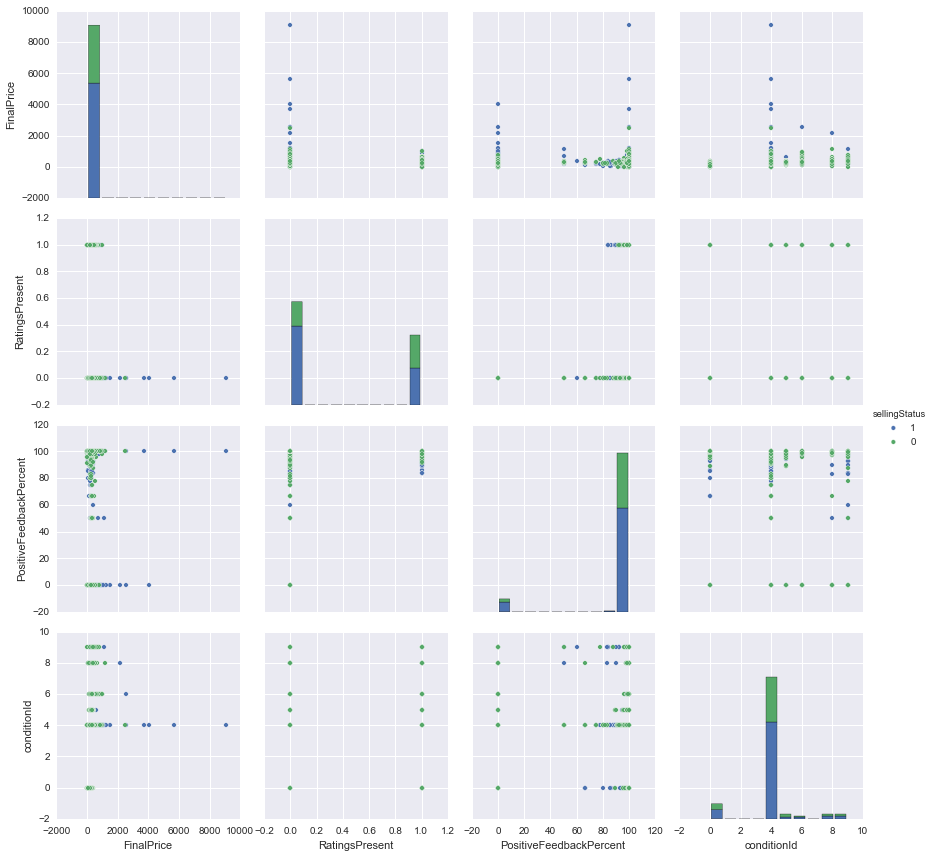

In [42]:
import seaborn as sns
sns.set()

sns.pairplot(df, hue='sellingStatus', vars=['FinalPrice','RatingsPresent','PositiveFeedbackPercent','conditionId'], size=3)

We see that very few people have a positive feedback percent in the range between 0 and 100, and that most of the ratings are either near 0% or near 100%. This tells us that very few ebay sellers are polarizing - either they are consistently bad or good, or some of those near 0% and 100% haven't sold many items so their small sample size naturally condones something near 0% or 100%. The most common condition of an item is conditionId 4, which, according to our dataframe_manipulation ipython notebook, indicates a conditionId of "Used". Everyone with a 0% positive feedback rating, irregardless of item condition, did not successfully sell their item. The vast majority of people also have positive feedback, which is good for worldly morality! Interestingly, while overall our dataframe is split ~65% sold 35% didn't sell, when people made their ratings present, a larger portion of them failed to sell. 

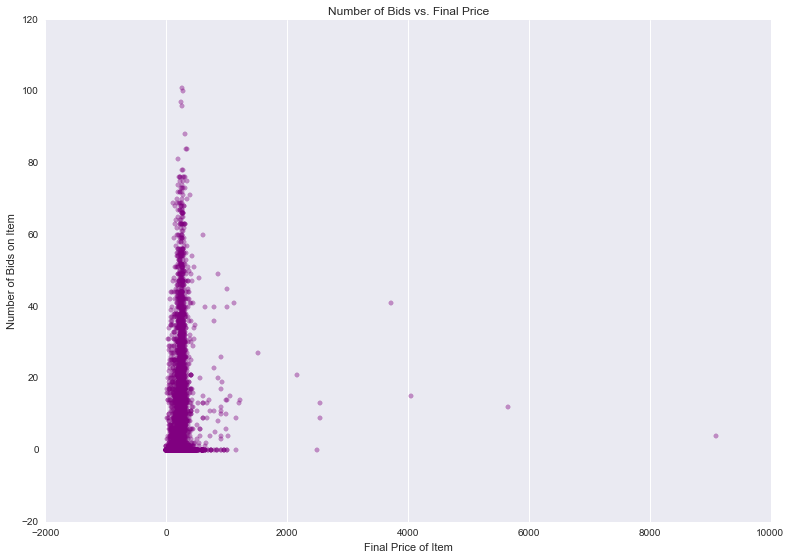

In [43]:
fig, ax1 = plt.subplots(figsize = (13,9))
ax1.yaxis.grid(False)
plt.scatter(df['FinalPrice'],df['BidCount'], alpha=.4, color='purple');
plt.title("Number of Bids vs. Final Price")
ax1.set_xlabel("Final Price of Item");
ax1.set_ylabel("Number of Bids on Item");

For more rudimentary examination, we see here that there is a small slope to a potential line drawn through this scatter data, suggesting that more bidding is slightly associated to a higher final price. Note the outliers here -- what iPhone sells for $9000. **Thankfully, those 10 or so dots are scarce compared to the ~9000 in the expected price range.** Good to note, however.

## Now we will do some Feature engineering

This is to figure out which variables actually make a distinction on item sellability. We separate our variables in similar manner to Homework 3. Certain parameters that are zero can be significant indicators of specific characteristics of an auction. For example, if the HitCount is zero, that means nobody really bothered to interact with the auction at all.

In [44]:
ZERO_IMPORTANT_VARIABLES = ['BidCount', 'HitCount', 'nPhotos', 'FeedbackScore', 'PositiveFeedbackPercent',
                           'NegFeedback30Day', 'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day']
STANDARDIZABLE = ZERO_IMPORTANT_VARIABLES + ['FinalPrice','auctionLength', 'HandlingTime', 'FeedbackScore', 
                  'PositiveFeedbackPercent', 'Quantity', 'nPaymentMethods', 'nShippingCountries', 'auctionLength']
INDICATORS = []

**We go ahead and make our list of indicators, making sure to not duplicate indicator names based on the list they are in.**

In [45]:
for v in df.columns:
    if v != 'sellingStatus':
        l=df[v].unique()
        if len(l) <= 10:
            if v not in STANDARDIZABLE:
                dftouse.rename(columns={v:'i_'+v}, inplace=True)
                INDICATORS.append('i_'+v)
            else:
                dftouse['i_'+v]=(dftouse[v] > 0.0)*1
                INDICATORS.append('i_'+v)
            print v, l

for v in ZERO_IMPORTANT_VARIABLES:
    dftouse['i_'+v]=(dftouse[v] > 0.0)*1
    INDICATORS.append('i_'+v)
    print v
    
#INDICATORS.remove('i_sellingStatus')
print INDICATORS


country [1 0]
paymentMethod [1 0]
topRatedListing [False True]
AutoPay [False True]
AvailableForPickupDropOff [0 1]
BestOfferEnabled [False True]
GlobalShipping [False True]
HandlingTime [ 2.  3.  1.  0.]
ListingType [1 0]
QuantityThreshold [  0.  10.]
SellerBusinessType [2 1 0]
NewUser [False True]
nPaymentMethods [1 2 4 3]
conditionId [4 0 9 8 6 5]
bestOfferEnabled [False True]
buyItNowAvailable [False True]
expeditedShipping [True False]
shippingType [ 2.  0.  1.  3.  4.  8.]
oneDayShippingAvailable [False True]
RatingsPresent [False True]
enoughKeyWords [False True]
BidCount
HitCount
nPhotos
FeedbackScore
PositiveFeedbackPercent
NegFeedback30Day
NegFeedback365Day
PosFeedback30Day
PosFeedback365Day
['i_country', 'i_paymentMethod', 'i_topRatedListing', 'i_AutoPay', 'i_AvailableForPickupDropOff', 'i_BestOfferEnabled', 'i_GlobalShipping', 'i_HandlingTime', 'i_ListingType', 'i_QuantityThreshold', 'i_SellerBusinessType', 'i_NewUser', 'i_nPaymentMethods', 'i_conditionId', 'i_bestOfferEnab

We divide our dataframe up into a training and a test set in order to run our regressions and SVMs on the data. Our goal here is to figure out what probability of selling maximizes our profit, so we look to get the best estimate of sellingStatus so that we can use it later on.

In [46]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

In [47]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [48]:
mask.shape, mask.sum()

((9267,), 6486)

Here we standardize our two masks (train and test) separately to make them distinct so that we have an essentially independent dataset to test our predictor on. Doing so allows us to better understand if we are doing a good job with predicting *any* set of iPhone 5s 32gb auction data and not just predicting the data we already had really well.

In [49]:
from sklearn import preprocessing

#we make our training and testing sets w/ standarized
scaler = preprocessing.StandardScaler().fit(dftouse[mask][STANDARDIZABLE])
dftouse.loc[mask, STANDARDIZABLE] = scaler.transform(dftouse[mask][STANDARDIZABLE]) 
dftouse.loc[~mask,STANDARDIZABLE] = scaler.transform(dftouse[~mask][STANDARDIZABLE])


dftouse[mask].head()

,i_country,itemId,i_paymentMethod,postalCode,sellingStatus,i_topRatedListing,i_AutoPay,i_AvailableForPickupDropOff,i_BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,i_GlobalShipping,HandlingTime,HitCount,i_ListingType,Location,MinimumToBid,ProductID,Quantity,i_QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,i_SellerBusinessType,i_NewUser,nPhotos,nPaymentMethods,nShippingCountries,i_conditionId,i_bestOfferEnabled,i_buyItNowAvailable,i_expeditedShipping,i_shippingType,i_oneDayShippingAvailable,i_RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,i_enoughKeyWords,i_HandlingTime,i_nPaymentMethods,i_BidCount,i_HitCount,i_nPhotos,i_FeedbackScore,i_PositiveFeedbackPercent,i_NegFeedback30Day,i_NegFeedback365Day,i_PosFeedback30Day,i_PosFeedback365Day
0,1,131642735687,1,10590,1,False,False,0,False,2.730381,NaN,-0.466801,False,0.420599,-0.033842,1,"South Salem, New York",204.59,NaN,-0.044197,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,-0.222416,0.302546,2,False,-0.802638,-0.070175,-0.834319,4,False,False,True,2,False,False,NaN,-0.157045,-0.239409,-0.276662,-0.311321,0.052604,False,1,1,1,1,1,1,1,0,0,1,1
2,1,252155964081,1,98104,1,False,False,0,False,-0.302216,NaN,-0.906112,False,0.420599,-0.037339,1,"Seattle, Washington",155.00,168534287,-0.044197,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.222555,0.073615,1,False,-1.131543,-0.070175,-0.834319,4,False,False,False,1,False,False,NaN,-0.157045,-0.203261,-0.289689,-0.307222,-0.058036,True,1,1,1,1,1,1,1,0,1,1,1
3,1,252163774777,1,98104,1,False,False,0,False,-0.461827,NaN,-1.380060,False,0.420599,-0.041314,1,"Seattle, Washington",100.00,168553370,-0.044197,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.222555,0.073615,1,False,0.512982,-0.070175,-0.834319,0,False,False,True,0,False,False,NaN,-0.157045,-0.203261,-0.289689,-0.307222,-0.058036,True,1,1,1,1,1,1,1,0,1,1,1
4,1,252171170160,1,98104,1,False,True,0,False,-0.142606,NaN,-1.406637,False,0.420599,-0.007291,1,"Seattle, Washington",97.00,168534287,-0.044197,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.222555,0.073615,1,False,-1.131543,-0.070175,-0.834319,4,False,False,False,1,False,False,NaN,-0.157045,-0.203261,-0.289689,-0.307222,-0.058036,True,1,1,1,1,1,1,1,0,1,1,1
5,1,252171162991,1,98104,1,False,False,0,False,-0.302216,NaN,-1.530661,False,0.420599,-0.015559,1,"Seattle, Washington",83.00,168553370,-0.044197,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.222555,0.073615,1,False,0.512982,-0.070175,-0.834319,0,False,False,True,0,False,False,NaN,-0.157045,-0.203261,-0.289689,-0.307222,-0.058036,True,1,1,1,1,1,1,1,0,1,1,1


In [50]:
lcols=list(dftouse.columns)
print lcols
lcols.remove(u'sellingStatus')
print len(lcols)

['i_country', 'itemId', 'i_paymentMethod', 'postalCode', 'sellingStatus', 'i_topRatedListing', 'i_AutoPay', 'i_AvailableForPickupDropOff', 'i_BestOfferEnabled', 'BidCount', 'BuyItNowPrice', 'FinalPrice', 'i_GlobalShipping', 'HandlingTime', 'HitCount', 'i_ListingType', 'Location', 'MinimumToBid', 'ProductID', 'Quantity', 'i_QuantityThreshold', 'ShipToLocations', 'Title', 'UserID', 'FeedbackScore', 'PositiveFeedbackPercent', 'i_SellerBusinessType', 'i_NewUser', 'nPhotos', 'nPaymentMethods', 'nShippingCountries', 'i_conditionId', 'i_bestOfferEnabled', 'i_buyItNowAvailable', 'i_expeditedShipping', 'i_shippingType', 'i_oneDayShippingAvailable', 'i_RatingsPresent', 'AverageRating', 'NegFeedback30Day', 'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day', 'auctionLength', 'i_enoughKeyWords', 'i_HandlingTime', 'i_nPaymentMethods', 'i_BidCount', 'i_HitCount', 'i_nPhotos', 'i_FeedbackScore', 'i_PositiveFeedbackPercent', 'i_NegFeedback30Day', 'i_NegFeedback365Day', 'i_PosFeedback30Day', '

In [51]:
ccols=[]
for c in lcols:
    if c not in INDICATORS:
        ccols.append(c)


ccols.remove('itemId')
ccols.remove('postalCode')
#ccols.remove('sellingStatus')
ccols.remove('Location')
ccols.remove('ProductID')
ccols.remove('ShipToLocations')
ccols.remove('Title')
ccols.remove('UserID')
print len(ccols), len(INDICATORS)

18 30


In [52]:
dftouse.head()

,i_country,itemId,i_paymentMethod,postalCode,sellingStatus,i_topRatedListing,i_AutoPay,i_AvailableForPickupDropOff,i_BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,i_GlobalShipping,HandlingTime,HitCount,i_ListingType,Location,MinimumToBid,ProductID,Quantity,i_QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,i_SellerBusinessType,i_NewUser,nPhotos,nPaymentMethods,nShippingCountries,i_conditionId,i_bestOfferEnabled,i_buyItNowAvailable,i_expeditedShipping,i_shippingType,i_oneDayShippingAvailable,i_RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,i_enoughKeyWords,i_HandlingTime,i_nPaymentMethods,i_BidCount,i_HitCount,i_nPhotos,i_FeedbackScore,i_PositiveFeedbackPercent,i_NegFeedback30Day,i_NegFeedback365Day,i_PosFeedback30Day,i_PosFeedback365Day
0,1,131642735687,1,10590,1,False,False,0,False,2.730381,NaN,-0.466801,False,0.420599,-0.033842,1,"South Salem, New York",204.59,NaN,-0.044197,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,-0.222416,0.302546,2,False,-0.802638,-0.070175,-0.834319,4,False,False,True,2,False,False,NaN,-0.157045,-0.239409,-0.276662,-0.311321,0.052604,False,1,1,1,1,1,1,1,0,0,1,1
1,1,262126933108,1,35004,1,False,False,0,False,-0.222411,NaN,0.046215,False,1.777815,-0.058961,1,"Moody, Alabama",265.00,NaN,-0.044197,0,US,apple iphone 5s 32gb,forwhlrcr1965,-0.203468,0.302546,1,False,-1.131543,-0.070175,-0.834319,4,False,False,True,0,False,False,NaN,-0.157045,-0.239409,-0.285347,-0.302099,-0.058036,False,1,1,1,1,1,1,1,0,0,1,1
2,1,252155964081,1,98104,1,False,False,0,False,-0.302216,NaN,-0.906112,False,0.420599,-0.037339,1,"Seattle, Washington",155.00,168534287,-0.044197,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.222555,0.073615,1,False,-1.131543,-0.070175,-0.834319,4,False,False,False,1,False,False,NaN,-0.157045,-0.203261,-0.289689,-0.307222,-0.058036,True,1,1,1,1,1,1,1,0,1,1,1
3,1,252163774777,1,98104,1,False,False,0,False,-0.461827,NaN,-1.380060,False,0.420599,-0.041314,1,"Seattle, Washington",100.00,168553370,-0.044197,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.222555,0.073615,1,False,0.512982,-0.070175,-0.834319,0,False,False,True,0,False,False,NaN,-0.157045,-0.203261,-0.289689,-0.307222,-0.058036,True,1,1,1,1,1,1,1,0,1,1,1
4,1,252171170160,1,98104,1,False,True,0,False,-0.142606,NaN,-1.406637,False,0.420599,-0.007291,1,"Seattle, Washington",97.00,168534287,-0.044197,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.222555,0.073615,1,False,-1.131543,-0.070175,-0.834319,4,False,False,False,1,False,False,NaN,-0.157045,-0.203261,-0.289689,-0.307222,-0.058036,True,1,1,1,1,1,1,1,0,1,1,1


Creating a set of **K**ernel **D**ensity **E**stimate plots (KDE) allows us to look at the non-indicator data that has a wide range of values to see how they vary depending on sellability or not. We see some interesting peaks throughout. For BuyitNows, a lower price was associated with more successful sales, as seen in the second plot. Also, a lot of the higher priced BuyItNows don't sell! Any Bidcount at all seems to be associated with a sale, whereas those little bumps throughout are probably associated with auctions that were cancelled in the middle of the auction period (this happens, according to eBay, time to time). Interestingly, average rating seems to have very little effect on auction outcome, and even in some respects there are many more people who didn't sell with a high rating. This is probably related to a trend above in the grid plot, where we noted "Interestingly, while overall our dataframe is split ~65% sold 35% didn't sell, when people made their ratings present, a larger portion of them failed to sell."

BidCount
BuyItNowPrice
FinalPrice
HandlingTime
HitCount
MinimumToBid
Quantity
FeedbackScore
PositiveFeedbackPercent
nPhotos
nPaymentMethods
nShippingCountries
AverageRating
NegFeedback30Day
NegFeedback365Day
PosFeedback30Day
PosFeedback365Day
auctionLength


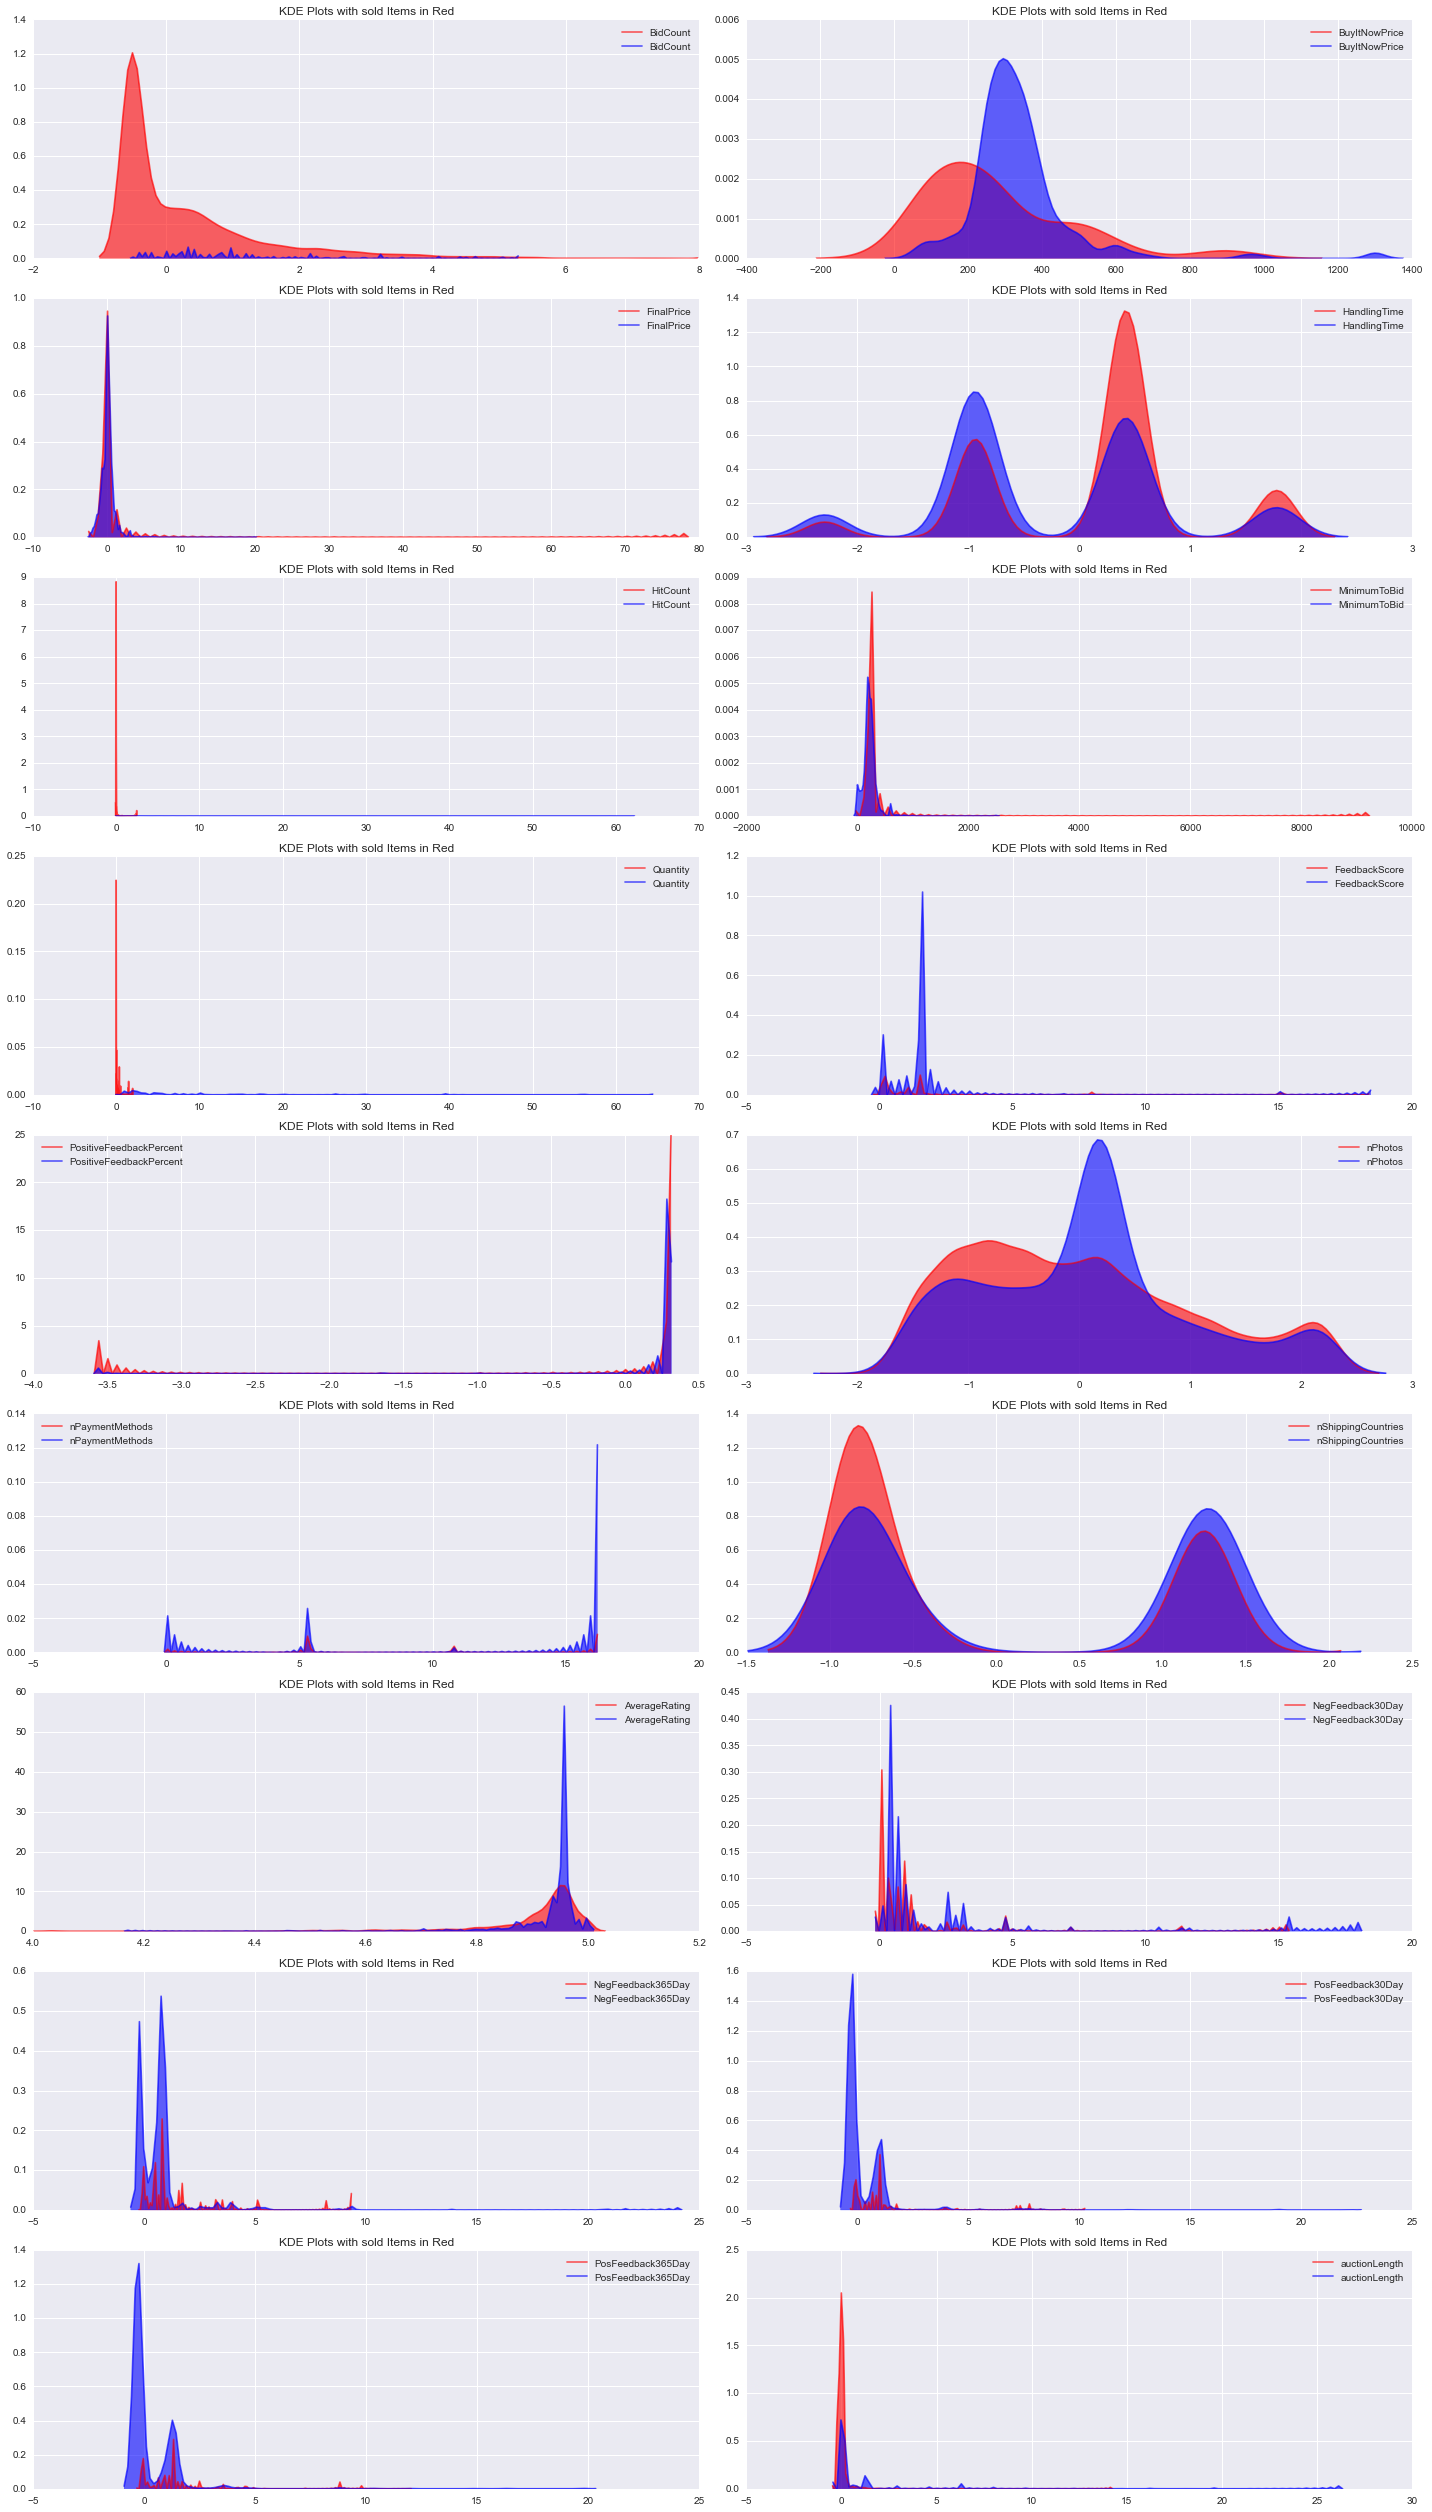

In [53]:
fig, axes = plt.subplots(nrows=9, ncols=2, sharex=False, sharey=False, figsize=(20, 35), 
                         tight_layout=True)
for ax, ccol in zip(axes.ravel(), ccols):
    
    #plot mean values per year based on response to mailing
    df_col = dftouse[ccol]
    print ccol
    sns.kdeplot(df_col[dftouse['sellingStatus'] == 1], color='r', alpha=.6, ax=ax, shade=True, legend=True)
    sns.kdeplot(df_col[dftouse['sellingStatus'] == 0], color='b', alpha=.6, ax=ax, shade=True)
    ax.set_title("KDE Plots with sold Items in Red")

Next we do a similar binary plot of sold vs. not sold for our indicators. How each of these are defined is explained in the dataframe_manipulation notebook in the mapping section.

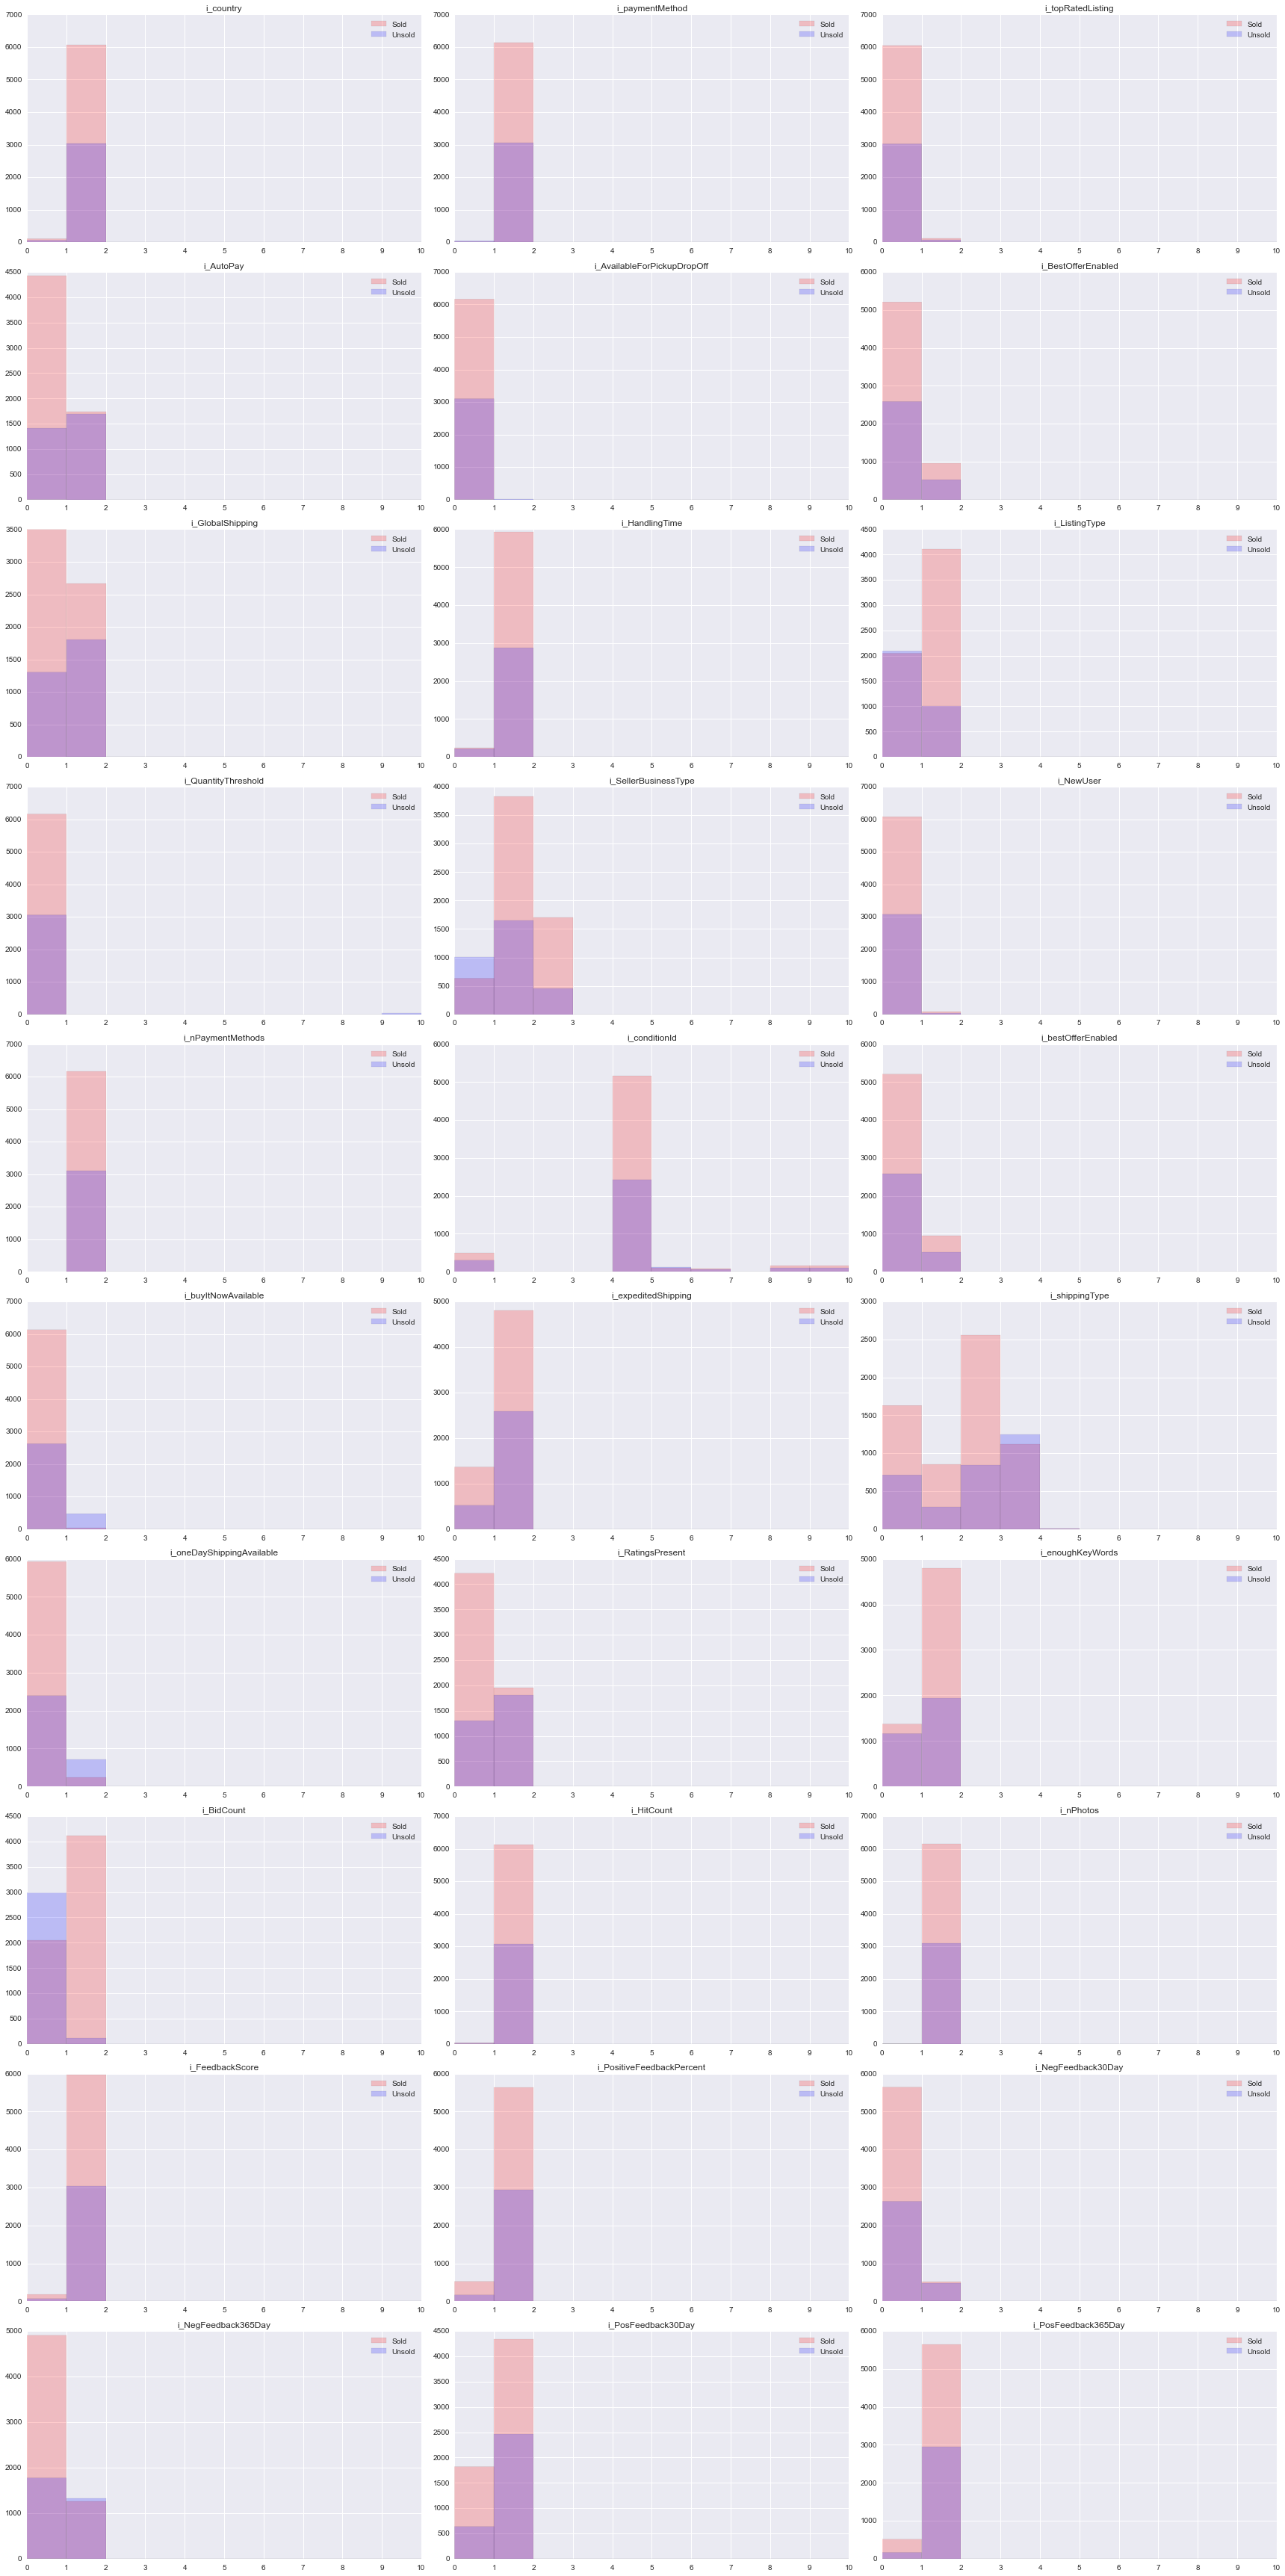

In [54]:
#setup similar layout
fig, axes = plt.subplots(nrows=10, ncols=3, figsize = (24,48),
                         tight_layout=True)

positives = dftouse[dftouse['sellingStatus'] == 1]
negatives = dftouse[dftouse['sellingStatus'] == 0]

for ax, data in zip(axes.ravel(), INDICATORS):
    ax.hist(positives[data].values, bins=10, range=[0,10], color = 'r', alpha = 0.2, label = 'Sold', rwidth=10)
    ax.hist(negatives[data].values, bins=10, range=[0,10], color = 'b', alpha = 0.2, label = 'Unsold', bottom=1)
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax.legend()
    ax.set_title(data)

We notice some obvious indications, like that with autoPay, where, while having autopay is most common (the majority of histogram values are in the 1 bin), the distribution of sold or not sold moves much more heavily toward not sold when autoPay isn't an option (bin 0). Also, if one has had negative feedback in the last year, that seems to in higher probability of not selling in comparison to negative feedback in the bast 30 days. We would have thought, intuitively, that more recent negative feedback would be taken as more relevant, but perhaps longstanding negative feedback without improvement is more damaging.

In [55]:
from sklearn.svm import LinearSVC

We remove the columns below from our current analysis because they contain NaN values or are not all workable indicating quantities. It would be interesting to do an analysis of how location affects sellability, but that isn't the crux of our analysis right now.

In [56]:

lcols.remove('UserID')
lcols.remove('itemId')
lcols.remove('Title')
lcols.remove('ShipToLocations')
lcols.remove('Location')
lcols.remove('postalCode')
lcols.remove('ProductID')
lcols.remove('AverageRating')
lcols.remove('BuyItNowPrice')
lcols.remove('MinimumToBid')


From here on out we'll follow the process that we learned about in HW3 for creating classifiers for our data sets.  We'll first create a classifier using LinearSVC to implement a Linear SVM.  This will be useful later when we tackle the question of whether we should sell our iPhone on eBay or elsewhere.  We are going with a linear model because our data set is large and linear is faster than kernelized and other SVM models.  We decided that we would fit over "sellingStatus" because there were two many possibilities for "FinalPrice" that it wouldn't be feasible to try and pin a few down, while for "sellingStatus" there are only two possibilities (whether or not the item is sold). We give credit to some of the given code in HW3 for setting up this analysis.

In [57]:
clfsvm=LinearSVC(loss="hinge")
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Xmatrix=dftouse[lcols].values
Yresp=dftouse['sellingStatus'].values

In [58]:
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

We then use GridSearchCV over our parameter grid of regularization coefficients (found in the Cs array) to get the best-fit classifier via 5-fold cross validation.  This will then give us the best parameter value, as well as the accuracy.

In [59]:
from sklearn.grid_search import GridSearchCV
gs=GridSearchCV(clfsvm, param_grid={'C':Cs}, cv=5)
gs.fit(Xmatrix_train, Yresp_train)
print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

BEST {'C': 1.0} 0.809744064138 [mean: 0.72356, std: 0.04211, params: {'C': 0.001}, mean: 0.79479, std: 0.04197, params: {'C': 0.01}, mean: 0.80188, std: 0.04606, params: {'C': 0.1}, mean: 0.80974, std: 0.04220, params: {'C': 1.0}, mean: 0.80697, std: 0.04889, params: {'C': 10.0}, mean: 0.65233, std: 0.15618, params: {'C': 100.0}]


In [60]:
print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
best = gs.best_estimator_
best.fit(Xmatrix_train, Yresp_train)
best.score(Xmatrix_test, Yresp_test)

BEST {'C': 1.0} 0.809744064138 [mean: 0.72356, std: 0.04211, params: {'C': 0.001}, mean: 0.79479, std: 0.04197, params: {'C': 0.01}, mean: 0.80188, std: 0.04606, params: {'C': 0.1}, mean: 0.80974, std: 0.04220, params: {'C': 1.0}, mean: 0.80697, std: 0.04889, params: {'C': 10.0}, mean: 0.65233, std: 0.15618, params: {'C': 100.0}]


0.85293060050341607

In [61]:
param_acc = best.score(Xmatrix_test, Yresp_test)

Now that we have tested out the process of determining the best parameters, we will make the process quicker by writing a function, cv_optimize, to do so.  We never call this function explicitly, because we'll instead use the function after, do_classify, to create our classifiers.

In [62]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_folds=5,score_func=None):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds,scoring=score_func)
    gs.fit(X, y)
    best = gs.best_estimator_
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    return best

In [63]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

We'll then use this function to train our data on the Linear SVM.

In [64]:
%%time
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, 'sellingStatus',1, mask=mask)

using mask
BEST {'C': 10.0} 0.814677767499 [mean: 0.72356, std: 0.04211, params: {'C': 0.001}, mean: 0.79479, std: 0.04197, params: {'C': 0.01}, mean: 0.80173, std: 0.04593, params: {'C': 0.1}, mean: 0.81036, std: 0.04100, params: {'C': 1.0}, mean: 0.81468, std: 0.04067, params: {'C': 10.0}, mean: 0.76241, std: 0.08839, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.85
[[ 740  191]
 [ 217 1633]]
########################################################
CPU times: user 16.9 s, sys: 225 ms, total: 17.2 s
Wall time: 18.2 s


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Now that we have successfully split our data into the testing and training sets, we can save them in a dictionary to call them at ease in the future.

In [65]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [66]:

##this tells us that most of our values are closer to 0 than 1, which means most were successful sales
print "whole data set", dftouse['sellingStatus'].mean()#Highly asymmetric
print "training set", dftouse['sellingStatus'][mask].mean(), "test set", dftouse['sellingStatus'][~mask].mean()

whole data set 0.665155929643
training set 0.665124884366 test set 0.665228335131


## Creating the confusion matrix

Now we actually want to work thorugh and analyze our profits and costs, which will be key to helping us make a decision about whether we should sell on eBay vs. other venues.  We can start this off by creating a confusion matrix, which essentially visualizes the decisions to be made.  We also calculate the observed positive, observed negative, predicted positive, and predicted negative values.

In [67]:
ypred=clfsvm.predict(Xtest)
confusion_matrix(ytest, ypred)

array([[ 740,  191],
       [ 217, 1633]])

In [68]:
print "OP=", ytest.sum(), ", ON=",ytest.shape[0] - ytest.sum()

OP= 1850 , ON= 931


In [69]:
print "PP=", ypred.sum(), ", ON=",ytest.shape[0] - ypred.sum()

PP= 1824 , ON= 957


Now we're getting into the crux of our profit & cost calculations.  We must consider 4 costs: true positive (we predict that it'll be more profitable to sell on eBay, and it is in fact true), true negative (we predict that it'll be more profitable to sell elsewhere, which is in fact true), false positive (we predict that it'll be more profitable to sell on eBay, which is false), and false negative (we predict that it'll be more profitable to sell elsewhere, when in fact that is false).  In creating these costs, we must consider types of costs.  On a physical level, listing our product can have one of a few costs, depending on what features we use - the average is approximately 4.20 USD.  We can then also consider the opportunity cost, i.e. the difference in profit we would earn from selling on other sources vs. eBay, and vice versa.  To do so we must consider whether the product is used or new.  From looking at other sources such as Apple's own policy, and what Verizon and AT&T do (including others like what happens on Craigslist), we see that on average, used iPhone 5s's tend to sell for around 225 USD, while new ones tend to sell around 280 USD.  To calculate the actual profit we will earn, we will again consider whether the product is new or old, factoring the probability of it being one of those two conditions.

In [70]:
# taking approx. average cost of listing based on whether using images, bold, short burst shor auctions, etc
listing_fee = 4.2

## we calcluate how many of our listings are top rated listings assuming our data is an simple random sample to get
## a probability of a listing being a top rated listing
size_df = float(len(dftouse.index))
y = float(len(dftouse[dftouse['i_topRatedListing'] == True]))
prob_toprated = y/size_df

## we get 90% of the profit from the sale, and if you are a top rated listing, you get %20 percent off this 10% charge
profit_margin=.9 +(.02 * prob_toprated)

## We calculate the true positive cost using the listing fee and subtracting off the profit made. We have to 
## average over new or used to make the mean better weighted for the "value" of the iPhone. We take the used value to 
## be 70% of the new value based on the fact that Apple currently sells the new one for $500 and refurbished for $340
## BestBuy: http://www.bestbuy.com/site/apple-refurbished-iphone-5s-32gb-cell-phone-unlocked-silver/1311862035.p?id=mp1311862035&skuId=1311862035
## Apple New: http://www.apple.com/shop/buy-iphone/iphone5s/32gb-space-gray

new = float(len(dftouse[dftouse['i_conditionId'] == 0]))
#probability of a sample being new
prob_new = new/size_df
#probability of a sample being old
prob_used = 1 - prob_new
#calculating the expected profit across all old and new samples
profit = ((df.FinalPrice.mean())*prob_new + (df.FinalPrice.mean())*(.7 * prob_used))*profit_margin

# As of December 10, 2015, Apple offers up to $320 dollars for iphone take-ins:
# http://www.apple.com/iphone/trade-in/?cid=&cp=em-P0016950-349230&sr=em
# However, other places, such as verizon and AT&T, take iphones in anwhere from 135-300 on average
# We scale the average of these for new and used eBay items, and make this part of our opportunity cost
diff = prob_new * (280 - df.FinalPrice.mean()*profit_margin) + prob_used*(225-(.7*df.FinalPrice.mean()*profit_margin))

#True Positive Cost: We predict that it is more profitable to sell on eBay, which is indeed true.
#Thus we must pay the cost of listing our item on eBay, as well as the opportunity cost
tpc = diff + listing_fee - profit

#True Negative Cost: We predict that it is more profitable to sell elsewhere, which is indeed true.
#Thus we don't pay the cost of listing our item on eBay, and we are rewarded with the negative of the opportunity cost
tnc= -diff

# False Negative Cost: We predict that it is more profitable to sell elsewhere, which is false.
#We don't have the listing fee this time because we didn't put our item on eBay, but we do pay the opportunity cost.
fnc = diff

# False Positive Cost: We predict that it is more profitable to sell on eBay, which is false.
#Because we put our item on eBay, we pay the listing fee.  We also pay the opportunity cost of not selling it elsewhere.
fpc = listing_fee + diff


We then concatenate these 4 costs into a risk/cost matrix, as seen below:

In [71]:
risk_matrix=np.array([[tnc, fpc],[fnc, tpc]])
risk_matrix

array([[ -62.44344884,   66.64344884],
       [  62.44344884, -100.64332785]])

While the risk matrix demonstrates the expected costs for all of our possible decisions, we are more concerned with the potential profit.  We can create a utility/profit matrix by taking the negative of the risk matrix

In [72]:
u = - risk_matrix

## to avoice writing -0
#u[0][0] = 0.
#u[0][1] = 0.
u

array([[  62.44344884,  -66.64344884],
       [ -62.44344884,  100.64332785]])

The matrix is great, but we need to be able to calculate the average profit across the different options.  Therefore we create a function average_profit_pp.

In [73]:
def average_profit_pp(y, ypred, u):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*u)/np.sum(c)
    return score

Now that we have all our data, let's think about ways to classify them.  At the simplest level, we could do one of two things: sell on eBay all the time, or never sell on eBay.  Because these are considered two extremes, we can call them our "baseline" cases.  Let's first calculate the profit for our first case: never selling anything on eBay (i.e. selling 0% on eBay).

In [74]:
#baseline classifier #1: don't sell anything
testsize = dftouse[~mask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print confusion_matrix(ytest, ypred_dste)
dsteval=average_profit_pp(ytest, ypred_dste, u)
dsteval

[[ 931    0]
 [1850    0]]


-20.634854184284475

Next we will consider the profits where we sell our phones on eBay every time (100%).

In [75]:
#baseline classifier #2: sell everything
testsize = dftouse[~mask].shape[0]
ypred_ste = np.ones(testsize, dtype="int")
print confusion_matrix(ytest, ypred_ste)
steval=average_profit_pp(ytest, ypred_ste, u)
steval

[[   0  931]
 [   0 1850]]


44.640455103336279

Now that we have calculated profits under the two baseline cases, we can then use them to determine the expected profit.

In [76]:
#calculating profit from SVM classifer using baselines
testsize = dftouse[~mask].shape[0]
ypred_svm=clfsvm.predict(Xtest)
print confusion_matrix(ytest, ypred_svm)
svmval=average_profit_pp(ytest, ypred_svm, u)
svmval

[[ 740  191]
 [ 217 1633]]


66.263782591950232

Thank goodness our expected profit is positive!  But can we do better?  Next we'll make another classifier, this time for logistic regression.  We then calculate the profit using this new classifier.

In [77]:
#logistic regression with Lasso based feature selection
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty="l1")
cvals = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clflog, Xtrain, ytrain, Xtest, ytest = do_classify(clf, cvals, dftouse,lcols, 'sellingStatus',1, mask=mask, reuse_split=reuse_split)

using mask
using reuse split
BEST {'C': 100.0} 0.824082639531 [mean: 0.64277, std: 0.01582, params: {'C': 0.001}, mean: 0.79186, std: 0.04863, params: {'C': 0.01}, mean: 0.82162, std: 0.03232, params: {'C': 0.1}, mean: 0.82254, std: 0.03758, params: {'C': 1.0}, mean: 0.82362, std: 0.03608, params: {'C': 10.0}, mean: 0.82408, std: 0.03631, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.87
Accuracy on test data:     0.86
[[ 728  203]
 [ 176 1674]]
########################################################


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [78]:
#calculating profit
testsize = dftouse[~mask].shape[0]
ypred_lreg=clflog.predict(Xtest)
print confusion_matrix(ytest, ypred_lreg)
lregval=average_profit_pp(ytest, ypred_lreg, u)
lregval

[[ 728  203]
 [ 176 1674]]


68.111145077390844

Look at that, we managed to increase our expected profit!  Now let's try to do compare our models in a slightly different, more visual, way.

##Creating ROC & Profit Curves

ROC curves are very useful for comparing the merits of different classifiers through visualization.  Making them essentially requires calculating the true positive rate (true positive / observed positive) and plotting it against the false positive rate (false positive / observed positive).

In [79]:
#Part 3
#function to make roc curves
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

As a test, we plot the logistic lasso ROC curve.

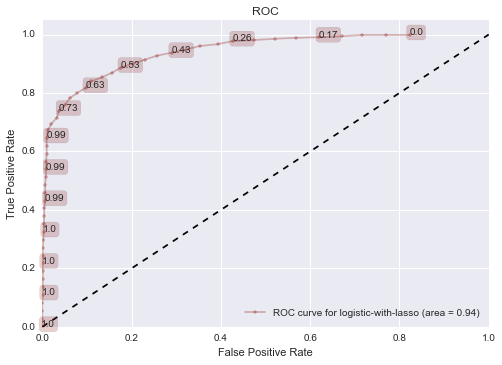

In [80]:
#logistic lasso ROC curve
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)

Looks reasonable enough.  Now let's try plotting logistic lasso against the all-features SVM.

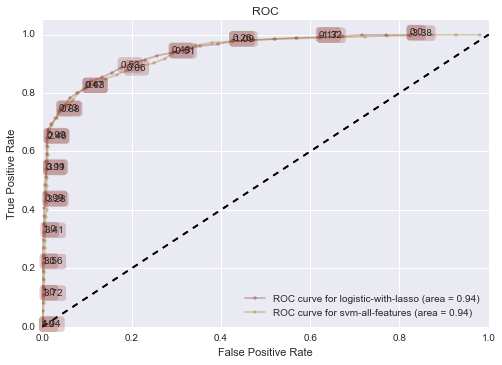

In [81]:
#logistic lasso vs. all features SVM
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
    make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=200, proba=False, skip=50)

We can see the logistic lasso ROC curve slightly outperforms the Linear SVM.

Next, let's compare the two by looking at tangent lines.  To make a tangent line, we first need to calculate the slope.

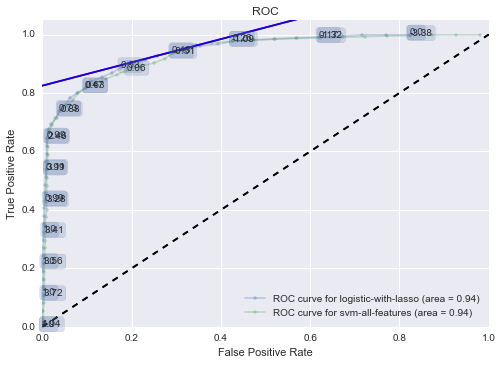

In [82]:
def rat(cost):
    return (cost[0,1] - cost[0,0])/(cost[1,0]-cost[1,1])
slope = rat(risk_matrix)*(np.mean(ytest==0)/np.mean(ytest==1))

z1=np.arange(0.,1., 0.02)
def plot_line(ax, intercept):
    plt.figure(figsize=(12,12))
    ax=plt.gca()
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
    make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=200, proba=False, skip=50)
    ax.plot(z1 , slope*z1 + intercept, 'k-')

#from IPython.html.widgets import interact, fixed
#interact(plot_line, ax=fixed(ax), intercept=(0.0,1.0, 0.005))

make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=200, proba=False, skip=50)
#.82 corresponds to the intercept predicted by calling the interact function
plt.plot(z1, slope*z1+0.825,'r')
plt.plot(z1, slope*z1+0.825,'b')

###Plotting Profit Curves
These ROC curves are interesting and all, but let's try to work with something we can more easily interpret: profit curves!  Before we can plot those, we must build up by writing multiple functions.  First we want to create a function that, given the TPR and FPR of a sample, calculates the percent of positive in a sample.  Next we want to calculate the average profit given the TPR and FPR, as well as the utility matrix.  We will then make a larger function for plotting the actual profit curves, building on the two functions we just made.

In [83]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc

In [84]:
def av_profit(tpr,fpr,util,priorp,priorn):
    profit = priorp*(util[1][1]*tpr+util[1][0]*(1.-tpr))+priorn*(util[0][0]*(1.-fpr) +util[0][1]*fpr)
    return profit
# -tnc, -fpc, -fnc, -tpc

In [85]:
def make_profit(name, clf, ytest, xtest, util, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_profit(tpr[i], fpr[i], util, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='utlity curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

We now plot the profit curves for the logistic lasso & linear SVM classifiers.

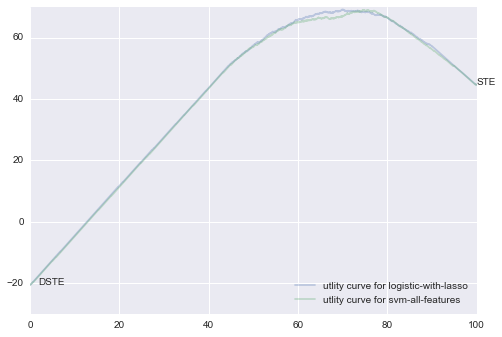

In [86]:
ax=make_profit("logistic-with-lasso", clflog, ytest, Xtest, u, ax=None, threshold=False, labe=200, proba=True)
make_profit("svm-all-features",clfsvm, ytest, Xtest, u, ax=None, threshold=False, labe=200, proba=False)
ax.annotate("STE",xy=(100,steval))
ax.annotate("DSTE",xy=(2,dsteval))
plt.legend(loc=4)

##Data Balancing and Feature Selection
As we can see above, our linear SVM slightly underperformed the logistic lasso regression.  We'll now try to improve the performance by selecting specific features that are most impactful.  We'll first experiment with this by comparing the relative coefficients assigned to each feature by the logistic lasso classifier.

In [87]:
def nonzero_lasso(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=lcols, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False)

In [88]:
lasso_importances=nonzero_lasso(clflog)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

,abscoef,coef
feature,,
i_BidCount,14.964455,14.964455
i_ListingType,9.966973,-9.966973
i_buyItNowAvailable,6.457527,-6.457527
i_PositiveFeedbackPercent,2.038945,-2.038945
i_paymentMethod,1.861120,1.861120
i_topRatedListing,1.173714,1.173714
i_HitCount,0.999312,0.999312
Quantity,0.873279,-0.873279
i_nPhotos,0.838536,-0.838536


Next we'll do a similar test, but this time we'll compare the correlation coefficients between each feature and the sellingstatus.

In [89]:
from scipy.stats.stats import pearsonr
correlations=[]
dftousetrain=dftouse[mask]
for col in lcols:
    r=pearsonr(dftousetrain[col], dftousetrain['sellingStatus'])[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

bpdf=pd.DataFrame(correlations).sort('abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
bpdf.head(25)

,abscorr,corr
feature,,
i_BidCount,0.593423,0.593423
BidCount,0.347821,0.347821
i_ListingType,0.324034,0.324034
i_buyItNowAvailable,0.303995,-0.303995
i_oneDayShippingAvailable,0.288845,-0.288845
i_SellerBusinessType,0.252941,0.252941
i_AutoPay,0.248842,-0.248842
i_RatingsPresent,0.240810,-0.240810
i_NegFeedback365Day,0.218737,-0.218737


As we can see above, there's quite some intersection between the two methods, as evidenced by the fact that many of the same features appear at the top of both dataframes.

Next we'll make a pipeline SVM, win which we do feature selection for our SVM, using correlation with sellingStatus.  First we make a Pearson scorer that returns the absolute correlation of the pearson coefficient.

In [90]:
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

In [91]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals

Now let's run the Pipeline SVM.  First we use SelectKBest to find the 25 most correlated/anti-correlated features.  We then create a pipeline, which uses the selected features to create a new estimator.

In [92]:
selectorlinearsvm = SelectKBest(k=25, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

Now we run the new classifier.

In [93]:
pipelinearsvm, _,_,_,_  = do_classify(pipelinearsvm, {"svm__C": [0.00001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, 'sellingStatus',1, reuse_split=reuse_split)

using reuse split
BEST {'svm__C': 100.0} 0.811594202899 [mean: 0.66297, std: 0.01891, params: {'svm__C': 1e-05}, mean: 0.71878, std: 0.03660, params: {'svm__C': 0.001}, mean: 0.78338, std: 0.04649, params: {'svm__C': 0.01}, mean: 0.81051, std: 0.02264, params: {'svm__C': 0.1}, mean: 0.80049, std: 0.04509, params: {'svm__C': 1.0}, mean: 0.80049, std: 0.04589, params: {'svm__C': 10.0}, mean: 0.81159, std: 0.04202, params: {'svm__C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.83
Accuracy on test data:     0.83
[[ 724  207]
 [ 268 1582]]
########################################################


Let's see what features had the greatest impact.

In [94]:
np.array(lcols)[pipelinearsvm.get_params()['select'].get_support()]

array(['i_AutoPay', 'BidCount', 'FinalPrice', 'i_GlobalShipping',
       'HandlingTime', 'i_ListingType', 'i_QuantityThreshold',
       'FeedbackScore', 'i_SellerBusinessType', 'nShippingCountries',
       'i_buyItNowAvailable', 'i_expeditedShipping', 'i_shippingType',
       'i_oneDayShippingAvailable', 'i_RatingsPresent',
       'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day',
       'auctionLength', 'i_enoughKeyWords', 'i_HandlingTime', 'i_BidCount',
       'i_NegFeedback30Day', 'i_NegFeedback365Day', 'i_PosFeedback30Day'], 
      dtype='|S27')

Now let's plot the new ROC curve using this new SVM.

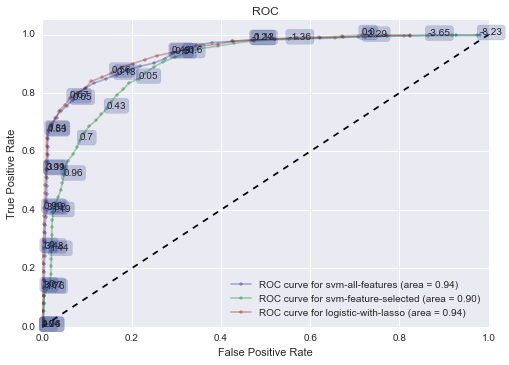

In [95]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=50);
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);

The new SVM performed slightly better than our first one, but still not as good as the logistic lasso.  That is because SVMs do not perform very well when the data is unbalanced.  To fix this, let's try balancing the data.

In [96]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg


4314 2172


From the code above we can see that there are many more positive samples in the training set than negative ones.  So what we can do is sample negative ($n_{-}$) samples from the positive ones in the training set, without replacement.

In [97]:
ineg = np.random.choice(jtrain[ytrain==1], n_neg, replace=False)


We can then concatenate all of these indices to create a new training set.

In [98]:
alli=np.concatenate((jtrain[ytrain==0], ineg))
alli.shape

(4344,)

In [99]:
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((4344, 45), (4344,))

We then store our newly created training sets.  It is important to note that throughout this balancing process we've left the test sets untouched, as it is essential to be able to test our data in real-world situations where data is not always balanced.

In [100]:
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

Now that we've successfully balanced our data, let's go through the usual process of classifying the data and plotting corresponding ROC and profit curves - hopefully we'll get better results.

In [101]:
clfsvm_b, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, 'sellingStatus',1,reuse_split = reuse_split_new)

using reuse split
BEST {'C': 0.1} 0.821362799263 [mean: 0.76427, std: 0.05323, params: {'C': 0.001}, mean: 0.81492, std: 0.01055, params: {'C': 0.01}, mean: 0.82136, std: 0.02541, params: {'C': 0.1}, mean: 0.75161, std: 0.14812, params: {'C': 1.0}, mean: 0.75368, std: 0.14393, params: {'C': 10.0}, mean: 0.75760, std: 0.06734, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.83
Accuracy on test data:     0.77
[[ 922    9]
 [ 620 1230]]
########################################################


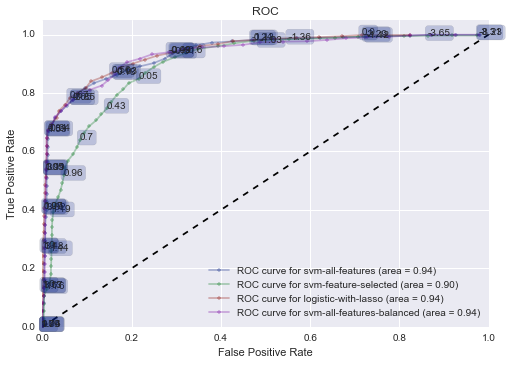

In [102]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=50);
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);
    make_roc("svm-all-features-balanced",clfsvm_b, ytest, Xtest, ax, labe=250, proba=False,  skip=50);

Hm, the ROC curve doesn't look very promising.  How about the profit curve?

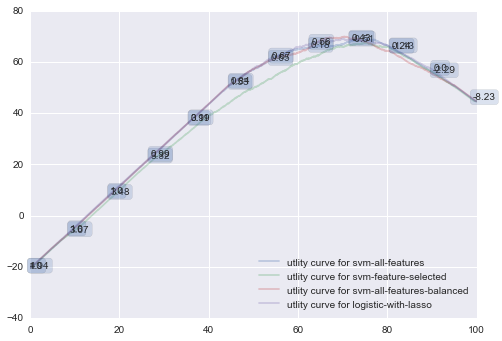

In [103]:
ax = make_profit("svm-all-features",clfsvm, ytest, Xtest, u, None, labe=250, threshold=True, proba=False)
make_profit("svm-feature-selected",pipelinearsvm, ytest, Xtest, u, ax, labe=250, proba=False);
make_profit("svm-all-features-balanced",clfsvm_b, ytest, Xtest, u, ax, labe=250, proba=False);
make_profit("logistic-with-lasso",clflog, ytest, Xtest, u, ax, labe=250, threshold=True);
plt.legend(loc=4)

The profit plot doesn't seem very reassuring.  Maybe we should try a different type of SVM.  Perhaps something non-linear like a kernelized one?  One downside of doing kernelization is that it is very expensive in terms of run-time for larger data sets, so we'll want to take a subsample of what we currently have.

In [104]:
from sklearn.svm import SVC

Running a kernelized SVM requires us to run our functions a bit differently from previous SVMs, as seen below

In [105]:
selectorsvm2 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm2 = Pipeline([('select2', selectorsvm2), ('svm2', SVC())])

In order that our code doesn't run for an inordinate amount of time, we will sample our sets to 300 each.

In [106]:
jtrain_new=np.arange(0, ytrain_new.shape[0])
ipos_new = np.random.choice(jtrain_new[ytrain_new==1], 300, replace=False)
ineg_new = np.random.choice(jtrain_new[ytrain_new==0], 300, replace=False)
subsampled_i=np.concatenate((ipos_new,ineg_new))
Xtrain_new2=Xtrain_new[subsampled_i]
ytrain_new2=ytrain_new[subsampled_i]

Once again, we will save the 4 sets in a dictionary, as seen below.

In [107]:
reuse_split_subsampled=dict(Xtrain=Xtrain_new2, Xtest=Xtest, ytrain=ytrain_new2, ytest=ytest)

Now that we have our data samples, let's try creating the kernelized SVM!  In the interest of time, we'll only use 3 gamma values.  We'll use this subsample to figure out the best parameters to use, then we'll run it on the entire set.

In [108]:
%%time
#your code here
params = {"svm2__C": [1e8], "svm2__gamma":[1e-9,1e-7,1e-5],"svm2__kernel":["rbf"]}
clfsvm_subsampled, Xtrain, ytrain, Xtest, ytest = do_classify(pipesvm2, params, dftouse,lcols, 'sellingStatus',1,reuse_split = reuse_split_subsampled)

using reuse split
BEST {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07, 'svm2__kernel': 'rbf'} 0.84 [mean: 0.64333, std: 0.02809, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-09, 'svm2__kernel': 'rbf'}, mean: 0.84000, std: 0.03472, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07, 'svm2__kernel': 'rbf'}, mean: 0.83000, std: 0.03358, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05, 'svm2__kernel': 'rbf'}]
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.80
[[ 813  118]
 [ 451 1399]]
########################################################
CPU times: user 1.89 s, sys: 22 ms, total: 1.91 s
Wall time: 1.97 s


Now that we know what parameters to use (C = 1e8, gamma = 1e-5), we'll run the classifier on the entire data set.

In [109]:
%%time
#your code here
selectorsvm3 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm3 = Pipeline([('select3', selectorsvm3), ('svm2', SVC(C=1e8,gamma=1e-9,kernel="rbf"))])
clfsvm_k, Xtrain, ytrain, Xtest, ytest = do_classify(pipesvm3, params, dftouse,lcols, 'sellingStatus',1,reuse_split = reuse_split_subsampled)

using reuse split
BEST {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07, 'svm2__kernel': 'rbf'} 0.84 [mean: 0.64333, std: 0.02809, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-09, 'svm2__kernel': 'rbf'}, mean: 0.84000, std: 0.03472, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07, 'svm2__kernel': 'rbf'}, mean: 0.83000, std: 0.03358, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05, 'svm2__kernel': 'rbf'}]
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.80
[[ 813  118]
 [ 451 1399]]
########################################################
CPU times: user 1.9 s, sys: 32.3 ms, total: 1.93 s
Wall time: 2.07 s


##Final Comparisons

And, as usual, we plot the corresponding ROC curve.

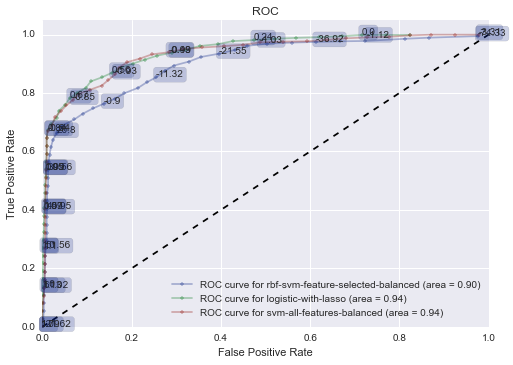

In [110]:
#Part 5
with sns.color_palette("dark"):
    ax=make_roc("rbf-svm-feature-selected-balanced",clfsvm_k, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);
    make_roc("svm-all-features-balanced",clfsvm_b, ytest, Xtest, ax, labe=250, proba=False,  skip=50);

Even after all this, the lasso still prevails!  Let's check the profit curve.

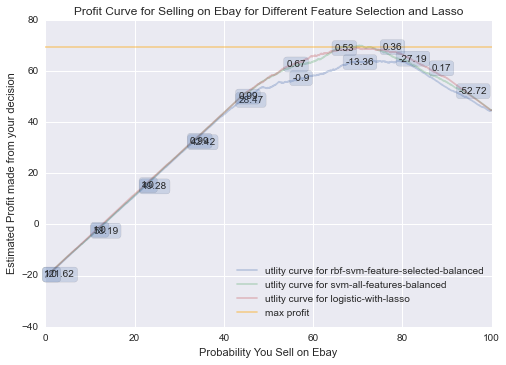

In [113]:
ax = make_profit("rbf-svm-feature-selected-balanced",clfsvm_k, ytest, Xtest, u, None, labe=300, threshold=True, proba=False)

make_profit("svm-all-features-balanced",clfsvm_b, ytest, Xtest, u, ax, labe=300, proba=False);
make_profit("logistic-with-lasso",clflog, ytest, Xtest, u, ax, labe=300, threshold=True);
plt.axhline(69.5, color='orange', alpha=.4, label='max profit')
plt.xlabel("Probability You Sell on Ebay")
plt.ylabel("Estimated Profit made from your decision")
plt.title("Profit Curve for Selling on Ebay for Different Feature Selection and Lasso")
plt.legend(loc=4)

## What this tells us

The x-axis on this plot tells us what expected profit would be at each probability of selling your iPhone 5s 32gb on eBay. We see that at around 75% probability of selling eBay, maximum predicted profit can occur, at a value of around $70. Moreover, everywhere above a probability around 13% results in a predicted positive profit, and at 100% probability of selling on eBay, a large profit (about 60% of the max) is expected to be received. Seems pretty sensible to list it on eBay, then! That dip starting at around 75% probability comes from opportunity costs and listing costs.

## What we can do to improve

To improve upon this model, we could do many things. First off, if we got a larger dataset, we would be able to use more of the variables that we had to get rid of because of sparse quantities. For example, eBay has this cool feature of setting a hidden “reserve” price that the buyer can’t see, but the buyer can only buy the item if their bid actually goes above this hidden price. However, only a handful of our around 10000 entries had used it. Since we couldn’t get any more entries, we couldn’t look into the effects of this feature. This happened for a few features, including setting a minimum required bid value above the previous (an increment minimum, if you will). Only about half our data had information on that, and our statistics couldn’t deal with NaN values very well. Also, we could only get data on the most recent eBay listings, so we couldn’t look into how selling an item varies based on season (e.g. near a holiday, or in the summer). We could also look into location to see if where you are affects how much your item sells for. The idea behind this is that if you are in a city, say, there are more people very close to you, and some people only like to buy items that don’t have to be shipped very far or can be picked up. Bonus points for that. Overall, though, it was cool to see that one could actually make an interesting prediction based on data right at hand. It really all comes down to that cost matrix!